**Forecasting a Time Series:**
- Task is to build a model capable of forecasting the number of passengers that will ride on bus and rail the next day.

In [1]:
import pandas as pd

path = '/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/data/CTA_-_Ridership_-_Daily_Boarding_Totals_20251110.csv'

df = pd.read_csv(path, parse_dates=['service_date'])

In [2]:
df.head(3)

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,"297,192","126,455","423,647"
1,2001-01-02,W,"780,827","501,952","1,282,779"
2,2001-01-03,W,"824,923","536,432","1,361,355"


In [3]:
df.columns = ['date', 'day_type','bus', 'rail', 'total']
df = df.sort_values(by='date').set_index('date')

In [4]:
df = df.drop('total', axis=1)
df = df.drop_duplicates()

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,"297,192","126,455"
2001-01-02,W,"780,827","501,952"
2001-01-03,W,"824,923","536,432"
2001-01-04,W,"870,021","550,011"
2001-01-05,W,"890,426","557,917"


In [6]:
import matplotlib.pyplot as plt

In [7]:
df['2019-03':'2019-05']

,day_type,bus,rail
date,,,
2019-03-01,W,"812,238","682,969"
2019-03-02,A,"454,119","349,392"
2019-03-03,U,"313,539","252,150"
2019-03-04,W,"699,086","635,353"
2019-03-05,W,"761,781","692,945"
...,...,...,...
2019-05-27,U,"298,987","256,757"
2019-05-28,W,"769,069","694,292"
2019-05-29,W,"791,059","717,681"


In [8]:
import numpy as np

In [9]:
df['bus'] = df['bus'].str.replace(',','')
df['rail'] = df['rail'].str.replace(',','')

In [10]:
df['bus'] = df['bus'].astype(np.int64)
df['rail'] = df['rail'].astype(np.int64)

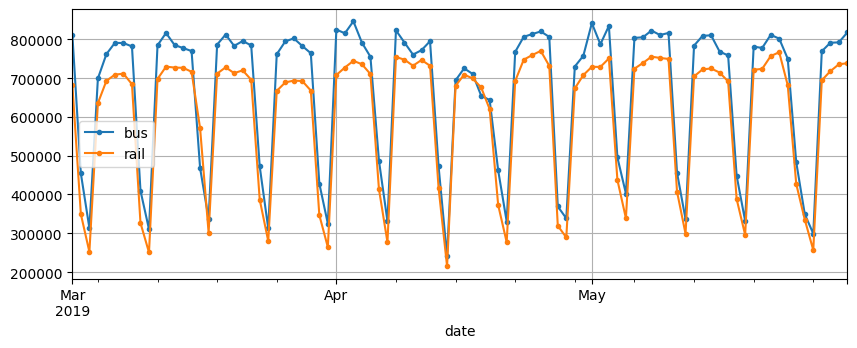

In [11]:
df['2019-03':'2019-05'].plot(grid=True, marker='.',figsize=(10,3.5))
plt.show()

- Looking at the plot above, we can see a similar pattern is clearly repeated every week. This is called the weekly seasonality. So strong that simply forecasting the next day's ridership by copying valies from a week earlier will yield reasonably good results. This is called naive forecasting: simply copying a past value to make the forecast. Naive forecasting is often a great baseline, and it can even be tricky to beat sometimes. 

- In general naive forecasting means copying the latest known value (e.g. forecasting that tomorrow will be the same as today). However, in ur case, copying values from the previous week would work better due to the **strong** weekly seasonality.

- To visualise these naive forecasts, let's overlay the two time series (for bus and rail) as well as the same timeseries lagged by one week (i.e. shifted toward the right) and also plot the difference between the two (i.e. value at time t minus that at time t-7) -. differencing


In [12]:
from dateutil.relativedelta import relativedelta

In [13]:
diff_7 = df[['bus','rail']].diff(7)['2019-03':'2019-05']

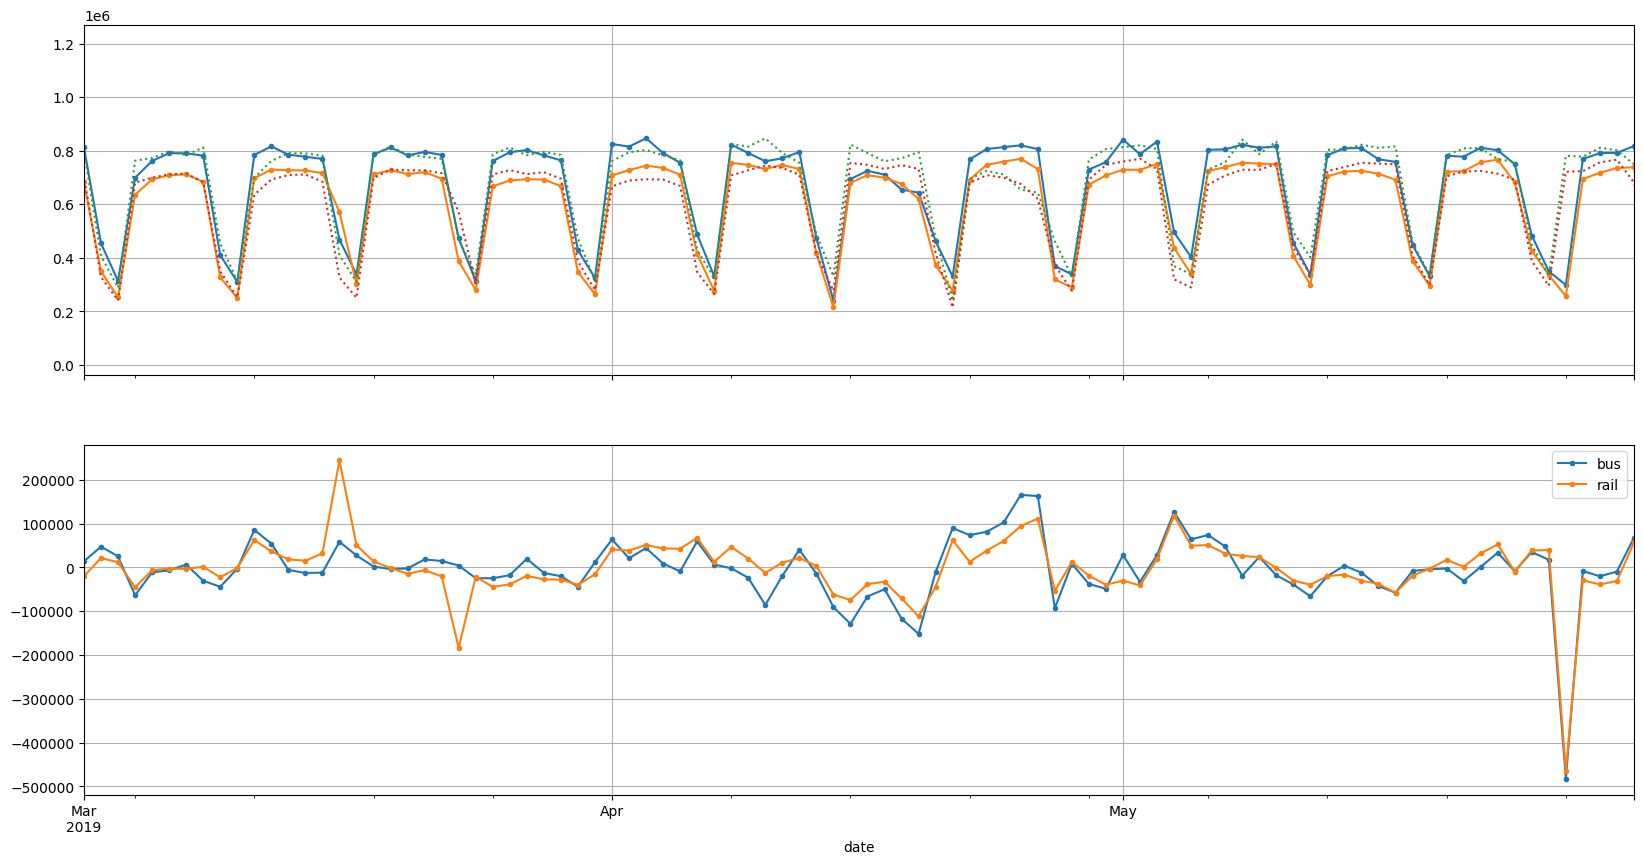

In [14]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20,10))
df.plot(ax=axs[0], legend=False, marker='.') # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=':') # lagged 
diff_7.plot(ax=axs[1], grid=True, marker='.') # 7 day difference time series
plt.show()

Not bad at all - notice how closely the lagged timeseries actually tracks the actual timeseries. When a timeseries is correlated with a lagged version of itself, we say that the timeseries is autocorrelated. As you can see - most of the differences are fairly small, except towards the end of May. Probably there was a holiday at the time - checking....

In [15]:
list(df.loc['2019-05-25':'2019-05-27']['day_type'])

['A', 'U', 'U']

so, from graph -> actual dips but naive forecast doesn't. Reality: there was a long weekend back then and the monday was the memorial day holiday. Lets measure the mean absolute error over the 3 month period we're arbitrarily focusing on March, April, and May 2019

remember - A is for saturdays, U is for sundays or holidays.

In [16]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

So, the naive forecast gets an MAE of about 43,916 riders, and about 42,143 rail riders. 

In [17]:
df.loc['2001-01-08',:].head()

day_type         W
bus         985221
rail        590706
Name: 2001-01-08 00:00:00, dtype: object

hard to tell at a glance how good or bad this mae is, so, let's put the forecast errors into perspective by dividing them by the target value:

In [18]:
targets = df[['bus','rail']]['2019-03':'2019-05']
(diff_7/targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

- So - what we just computed is the mean absolute percentage error (MAPE): it looks like the naive forecast gives us a MAPE of roughly 8.3% for bus and 9% for rail. Its interesting to note that the MAE for the rail forecast slightly looks better than the MAE for the bus forecasts, while the opposite is true for the MAPE. That's because the bus ridership is larger than the rail ridership, so naturally the forecast errors are also larger. But, putting the errors into perspective, it turns out that the bus forecasts are actually slightly better than the rail forecasts. 

- The MAE, MAPE, and MSE are among the common metrics that can be used to evaluate forecasts. Choosing the right metric as always is task dependent. For example - if the project suffers quadratically from large errors than from small ones, then MSE may be preferable as it penalizes large errors. 

- Looking at the time series there doesn't appear to be any significant monthly seasonality but lets check for yearly seasonality. We'll look at the data from 2001 to 2019. To reduce the risk of data snooping, we'll ignore more recent data for now. Let's also plot a 12-month rolling average for each timeseries to visualise long-term trends.

In [19]:
df[['bus','rail']].resample('M').mean()

/var/folders/_h/yzv4_kzj2yv3z5xh7lks3hpr0000gn/T/ipykernel_1260/1292944986.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[['bus','rail']].resample('M').mean()


,bus,rail
date,,
2001-01-31,807190.580645,474591.419355
2001-02-28,848889.000000,488188.178571
2001-03-31,865392.419355,498825.096774
2001-04-30,835126.366667,490444.533333
2001-05-31,862701.419355,507862.258065
...,...,...
2025-04-30,542728.633333,374914.500000
2025-05-31,527667.870968,379848.870968
2025-06-30,503232.566667,394294.600000


/var/folders/_h/yzv4_kzj2yv3z5xh7lks3hpr0000gn/T/ipykernel_1260/2608410564.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[['bus','rail']].resample('M').mean() # compute the mean for each month


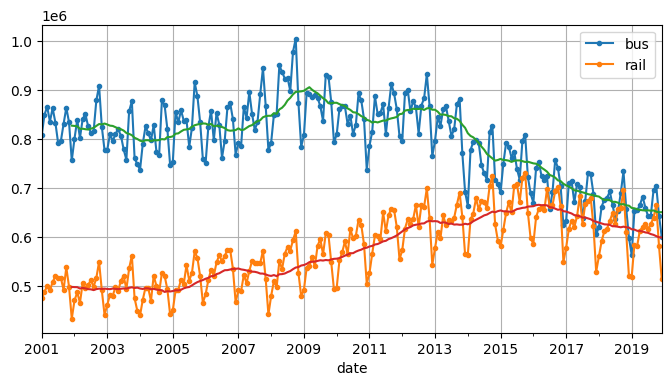

In [20]:
period = slice("2001","2019")

df_monthly = df[['bus','rail']].resample('M').mean() # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

There's definitely some yearly seasonality as well, although its noisier than the weekly seasonality, and more visible for rail series than for the bus series. We see peaks and troughs at roughly the same dates each year. 

Let's check what we get if we plot the 12-month difference

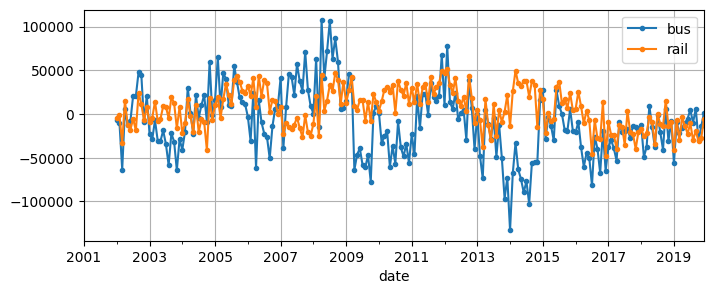

In [21]:
df_monthly.diff(12)[period].plot(grid=True, marker='.', figsize=(8,3))
plt.show()

- Notice - differencing not only removed the yearly seasonality, but it also removed the long term trends. For example, the linear downward trend initially present in the timeseries from 2016 to 2019 became a roughly constant negative value in the differenced timeseries. In fact differencing is a common technique used to remove trend and seasonality from a timeseries. This is because, it is easier to study a stationary timeseris, meaning one whose statistical properties remain constant overtime, without any seasonality or trend. Once you're able to make accurate forecasts on the differenced timeseries, its them easy to turn them to forecasts for the actual time series by just adding back the past values previously subtracted

**Preparing Data for ML Models:**
- Goal: Forecast the next day's ridership based on the ridership of the past 8 weeks of data (56 days). The inputs to the model will therefore be sequences (a single seq per day once the model is in production), each containing 56 values from timestep t-55 to t. for each sequence, the model will output a single value: the forecast for timestep t+1. 
- Training data: every 56-day window from the past as training data and the target will be the value immediately following it. 

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset

In [23]:
my_series = [0, 1, 2, 3, 4, 5]

In [24]:
seq_length = 3
chunk_size = seq_length + 1
chunks = [my_series[i:i+chunk_size] for i in range(len(my_series)-chunk_size+1)]

In [25]:
chunks

[[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5]]

In [26]:
class TimeSeriesDataset(Dataset):
    def __init__(self, chunks):
        self.chunks = chunks
    def __len__(self):
        return len(self.chunks)
    
    def __getitem__(self, index):
        series_chunk = self.chunks[index]
        return series_chunk[:-1], series_chunk[-1]

In [27]:
z = TimeSeriesDataset(torch.tensor(chunks))

In [28]:
z[0]

(tensor([0, 1, 2]), tensor(3))

In [29]:
z[1]

(tensor([1, 2, 3]), tensor(4))

Before training, we need to split our data into a training period, a validation period, and a test period. We will focus on the rail ridership for now. We will also scale it down by a factor of 1 million, to ensure the values aee near the 0-1 range. This plays nicely with the default weight initialization and learning rate:

In [30]:
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2025-08-27,W,653421,473422
2025-08-28,W,642222,520735
2025-08-29,W,630115,476265


In [31]:
rail_train = df['rail']['2016-01':'2018-12']/1e6
rail_valid = df['rail']['2019-01':'2019-05']/1e6
rail_test = df['rail']['2019-06':]/1e6

When dealing with time series, we generally want to split across time. However, in some cases we may be able to split along other dimensions, which will give a longer time period to train on. For example, if you have data about the financial health of 10k companies from 2001-2019, you might be able to split this data across different companies. Its very likely that many of these companies will be strongly correlated, though (e.g., whole economic sectors may go down or up jointly), if you've got correlated companies across the training and test sets, timeseries test set won't be useful as its measure of generalization error will be optimistically biased. 

Now we create our training and validation datasets. Since gradient descent expects instances in the training set to be independent and identically distributed, we must set the shuffle argument to true to the windows, but not their contents. 

In [50]:
seq_length = 56
chunk_size = seq_length+1
rail_train_chunks = [rail_train.values.tolist()[i:i+chunk_size] for i in range(len(rail_train.values.tolist())-chunk_size+1)]
rail_valid_chunks = [rail_valid.values.tolist()[i:i+chunk_size] for i in range(len(rail_valid.values.tolist())-chunk_size+1)]

In [52]:
rail_train_ds = TimeSeriesDataset(torch.tensor(rail_train_chunks))
rail_valid_ds = TimeSeriesDataset(torch.tensor(rail_valid_chunks))

In [55]:
len(rail_train_ds), len(rail_valid_ds)

(1040, 95)

In [56]:
rail_train_dl = DataLoader(rail_train_ds, batch_size=128, shuffle=True)
rail_valid_dl = DataLoader(rail_valid_ds, batch_size=128)

**Forecasting using a Linear Model:**

In [57]:
torch.manual_seed(1)

In [58]:
import torch.nn as nn

In [62]:
from utils.early_stopping import EarlyStopping

In [59]:
model = nn.Sequential(
    nn.Linear(seq_length, 1)
)

In [61]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = model.to(device)

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
criterion = nn.HuberLoss()
early_stopper = EarlyStopping(patience=50, checkpoint_path='linear_model.pt', restore_best_weights=True, verbose=True)

In [66]:
n_epochs = 500

train_loss = [0]*n_epochs
val_loss = [0]*n_epochs

for epoch in range(n_epochs):
    model.train()
    for x_batch,y_batch in rail_train_dl:
        # move the data to GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # compute the forward pass
        out = model(x_batch)
        # compute the loss
        loss = criterion(out, y_batch)
        # Compute the gradients
        loss.backward()
        # Backpropagation
        optimizer.step()
        # zero the gradients
        optimizer.zero_grad()
        # training loss computation
        train_loss[epoch] += loss.item()*y_batch.size(0)
    train_loss[epoch] /= len(rail_train_dl.dataset)

    # Validation step
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in rail_valid_dl:
            # move the data to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # forward pass
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_loss[epoch]+= loss.item()*y_batch.size(0)
        val_loss[epoch]/=len(rail_valid_dl.dataset)

        print(f'Epoch: {epoch+1}| Train loss: {train_loss[epoch]:.4f}| Val loss: {val_loss[epoch]:.4f}')

        # early stopping
        early_stopper(val_loss[epoch], model, optimizer, epoch)
        if early_stopper.should_stop:
            print("Stopping at epoch ",epoch)
            break   

/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:1139: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:1139: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:1139: UserWarning:

Epoch: 1| Train loss: 0.0672| Val loss: 0.0219
Metric improved to 0.0219. Checkpoint saved at epoch 0
Epoch: 2| Train loss: 0.0299| Val loss: 0.0181
Metric improved to 0.0181. Checkpoint saved at epoch 1
Epoch: 3| Train loss: 0.0226| Val loss: 0.0206
No improvement for 1 epoch(s)
Epoch: 4| Train loss: 0.0188| Val loss: 0.0210
No improvement for 2 epoch(s)
Epoch: 5| Train loss: 0.0189| Val loss: 0.0200
No improvement for 3 epoch(s)
Epoch: 6| Train loss: 0.0192| Val loss: 0.0172
Metric improved to 0.0172. Checkpoint saved at epoch 5
Epoch: 7| Train loss: 0.0180| Val loss: 0.0167
Metric improved to 0.0167. Checkpoint saved at epoch 6
Epoch: 8| Train loss: 0.0183| Val loss: 0.0175
No improvement for 1 epoch(s)
Epoch: 9| Train loss: 0.0184| Val loss: 0.0212
No improvement for 2 epoch(s)
Epoch: 10| Train loss: 0.0186| Val loss: 0.0174
No improvement for 3 epoch(s)
Epoch: 11| Train loss: 0.0185| Val loss: 0.0175
No improvement for 4 epoch(s)
Epoch: 12| Train loss: 0.0189| Val loss: 0.0184
No 

In [68]:
len(train_loss), len(val_loss)

(500, 500)

In [69]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 3.5731e-02, -9.1140e-03,  1.8272e-02,  2.4127e-02, -1.2483e-02,
                        2.4124e-02, -4.4977e-03,  1.9465e-02,  1.7949e-03,  7.9788e-03,
                       -3.5164e-03,  9.9178e-03, -1.2305e-03, -3.8680e-03,  8.6127e-03,
                        1.0385e-02,  7.4192e-03, -2.6162e-02,  3.6485e-02, -1.4943e-02,
                       -2.4153e-05, -4.9439e-03, -3.7795e-03,  3.7784e-03, -7.8841e-03,
                        1.6581e-02,  2.6057e-03,  3.7076e-02, -3.3021e-02,  2.9380e-02,
                        1.2776e-02,  9.3524e-03,  2.7255e-02, -2.2870e-02, -5.3726e-05,
                       -1.4007e-02,  3.4712e-02, -3.1396e-03, -6.9646e-04, -2.1969e-02,
                        3.0401e-02, -2.1070e-02,  2.6151e-02, -3.7854e-03,  1.2452e-03,
                        1.8481e-02, -1.0808e-02,  1.9158e-02,  2.9433e-03,  2.2111e-02,
                       -1.6429e-02,  3.8193e-03,  2.3127e-02, -1.5088e-03,  2.0330e-02,
      

In [70]:
checkpoint = torch.load('linear_model.pt')

In [73]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [74]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 3.5731e-02, -9.1140e-03,  1.8272e-02,  2.4127e-02, -1.2483e-02,
                        2.4124e-02, -4.4977e-03,  1.9465e-02,  1.7949e-03,  7.9788e-03,
                       -3.5164e-03,  9.9178e-03, -1.2305e-03, -3.8680e-03,  8.6127e-03,
                        1.0385e-02,  7.4192e-03, -2.6162e-02,  3.6485e-02, -1.4943e-02,
                       -2.4153e-05, -4.9439e-03, -3.7795e-03,  3.7784e-03, -7.8841e-03,
                        1.6581e-02,  2.6057e-03,  3.7076e-02, -3.3021e-02,  2.9380e-02,
                        1.2776e-02,  9.3524e-03,  2.7255e-02, -2.2870e-02, -5.3726e-05,
                       -1.4007e-02,  3.4712e-02, -3.1396e-03, -6.9646e-04, -2.1969e-02,
                        3.0401e-02, -2.1070e-02,  2.6151e-02, -3.7854e-03,  1.2452e-03,
                        1.8481e-02, -1.0808e-02,  1.9158e-02,  2.9433e-03,  2.2111e-02,
                       -1.6429e-02,  3.8193e-03,  2.3127e-02, -1.5088e-03,  2.0330e-02,
      

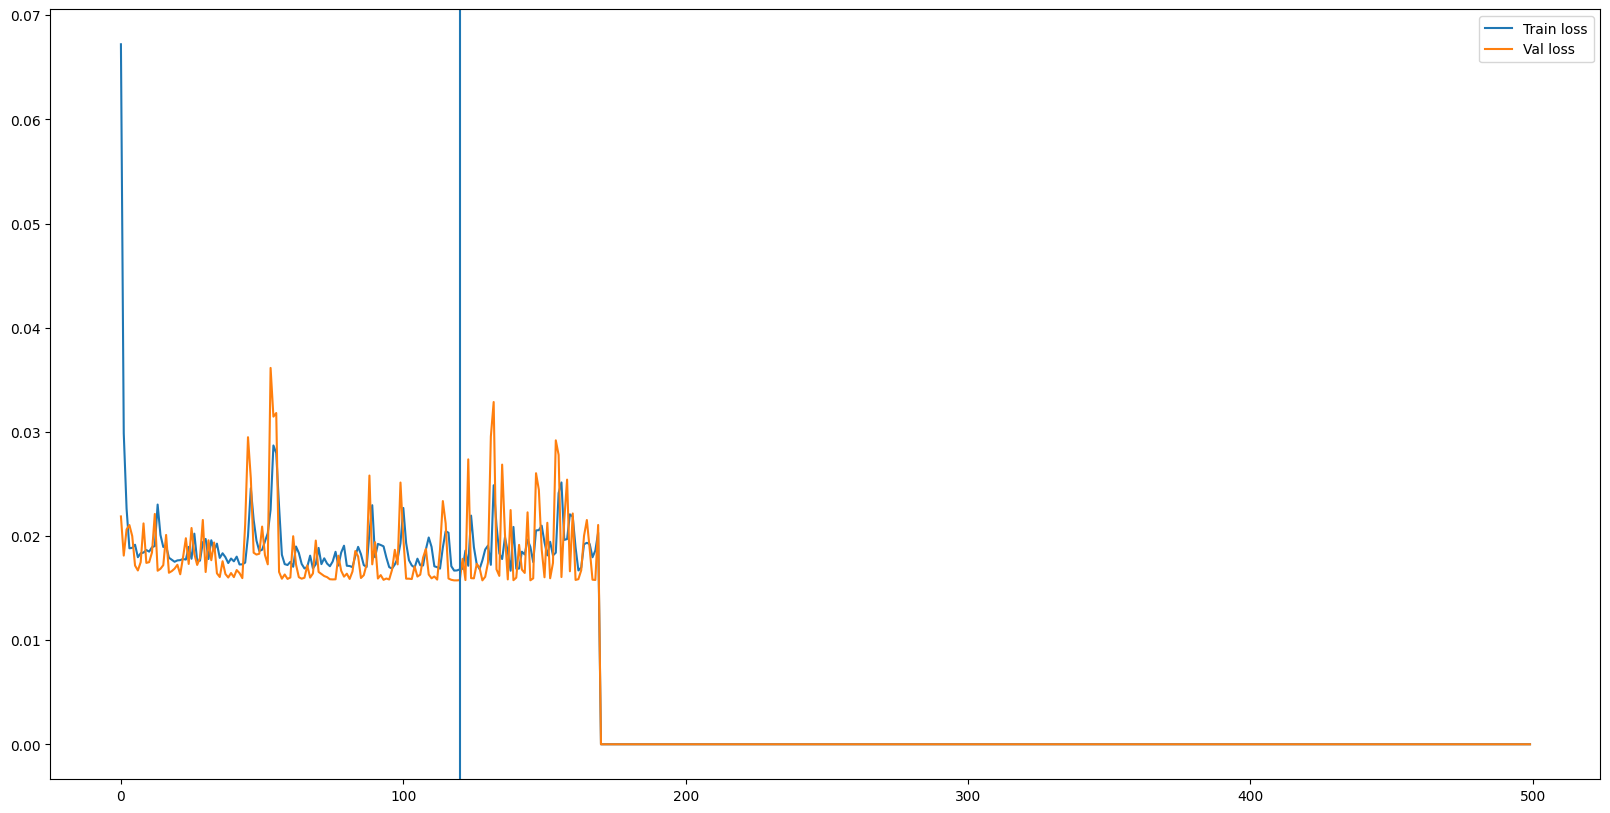

In [85]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(train_loss, label='Train loss')
ax.plot(val_loss, label='Val loss')
ax.axvline(120)
ax.legend()

From training - model achieves a validation loss of 15,735 - validation mae of 15,735 - better than naive forecasting.

In [89]:
checkpoint['metric']*1e6

15735.508874058723

Above, we've used a linear model - treated each instance of the sequence as independent and not dependent on the other. we've not utilised the learnings/the previous input data in the sequence. 

**Forecasting Using a Simple RNN:**

In [108]:
# creating a simple RNN layer - expects a sequence with just one feature and same outputs just one feature
simple_rnn = nn.Sequential(
    nn.RNN(1,1,batch_first=True)
)

In [109]:
simple_rnn = simple_rnn.to(device)

In [110]:
optimizer = torch.optim.Adam(simple_rnn.parameters(), lr=0.02)
criterion = nn.HuberLoss()
early_stopper = EarlyStopping(patience=50, checkpoint_path='simple_rnn.pt', restore_best_weights=True, verbose=True)

In [113]:
torch.randn(128,56).unsqueeze(2).shape

torch.Size([128, 56, 1])

In [115]:
n_epochs = 500

train_loss = [0]*n_epochs
val_loss = [0]*n_epochs

for epoch in range(n_epochs):
    simple_rnn.train()
    for x_batch,y_batch in rail_train_dl:
        # move the data to GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # compute the forward pass
        out, hn = simple_rnn(x_batch.unsqueeze(2))
        # compute the loss
        loss = criterion(hn[-1,:,:], y_batch)
        # Compute the gradients
        loss.backward()
        # Backpropagation
        optimizer.step()
        # zero the gradients
        optimizer.zero_grad()
        # training loss computation
        train_loss[epoch] += loss.item()*y_batch.size(0)
    train_loss[epoch] /= len(rail_train_dl.dataset)

    # Validation step
    simple_rnn.eval()
    with torch.no_grad():
        for x_batch, y_batch in rail_valid_dl:
            # move the data to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # forward pass
            out, hn = simple_rnn(x_batch.unsqueeze(2))
            loss = criterion(hn[-1,:,:], y_batch)
            val_loss[epoch]+= loss.item()*y_batch.size(0)
        val_loss[epoch]/=len(rail_valid_dl.dataset)

        print(f'Epoch: {epoch+1}| Train loss: {train_loss[epoch]:.4f}| Val loss: {val_loss[epoch]:.4f}')

        # early stopping
        early_stopper(val_loss[epoch], simple_rnn, optimizer, epoch)
        if early_stopper.should_stop:
            print("Stopping at epoch ",epoch)
            break   


/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:1139: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:1139: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:1139: UserWarning:

Epoch: 1| Train loss: 0.2221| Val loss: 0.0194
Metric improved to 0.0194. Checkpoint saved at epoch 0
Epoch: 2| Train loss: 0.0219| Val loss: 0.0306
No improvement for 1 epoch(s)
Epoch: 3| Train loss: 0.0274| Val loss: 0.0325
No improvement for 2 epoch(s)
Epoch: 4| Train loss: 0.0272| Val loss: 0.0295
No improvement for 3 epoch(s)
Epoch: 5| Train loss: 0.0240| Val loss: 0.0247
No improvement for 4 epoch(s)
Epoch: 6| Train loss: 0.0203| Val loss: 0.0203
No improvement for 5 epoch(s)
Epoch: 7| Train loss: 0.0181| Val loss: 0.0178
Metric improved to 0.0178. Checkpoint saved at epoch 6
Epoch: 8| Train loss: 0.0176| Val loss: 0.0171
Metric improved to 0.0171. Checkpoint saved at epoch 7
Epoch: 9| Train loss: 0.0177| Val loss: 0.0171
Metric improved to 0.0171. Checkpoint saved at epoch 8
Epoch: 10| Train loss: 0.0178| Val loss: 0.0173
No improvement for 1 epoch(s)
Epoch: 11| Train loss: 0.0175| Val loss: 0.0175
No improvement for 2 epoch(s)
Epoch: 12| Train loss: 0.0176| Val loss: 0.0176
No 

In [117]:
checkpoint = torch.load('simple_rnn.pt')

In [119]:
checkpoint['metric']*1e6

15712.350606918335